In [2]:
from pathlib import Path
import sys
import re
import json
import os
from collections import defaultdict
sys.path.append('../../src')
from common import splitIndexHeaderFromStr
sequencesPath = Path('../../datasets/hymns/sequences.txt')
assignmentsPath = Path('../../datasets/hymns/misc/assignments.json')
surveyPath = Path('../../datasets/hymns/misc/survey_results.csv')

In [3]:
# Map sequence index to the actual hymn name
with open(sequencesPath) as f:
    entries = re.split('\n\n', f.read())[:-1] # remove trailing empty space
reverseSequenceLookup = {} # index: sequenceName
for e in entries:
    index, hymnFile = splitIndexHeaderFromStr(e)
    filePath = Path(hymnFile)
    basename = filePath.stem
    reverseSequenceLookup[index] = basename

# Map hymn name to the list of assignmentAnswersLookup that reference it
with open(assignmentsPath) as f:
    allAssignments = json.load(f)
reverseAssignmentLookup = defaultdict(list) # Hymn name: assignments
for assignment, hymnPaths in allAssignments.items():
    for p in hymnPaths:
        name = p.split('\\')[-1].split('.')[0].split('-mono')[0]
        reverseAssignmentLookup[name].append(assignment)

# Map assignment name to the names of the two hymns it contains (in correct order)
with open(assignmentsPath) as f:
    allAssignments = json.load(f)
assignmentPositionLookup = defaultdict(list) # Hymn name: assignments
for assignment, hymnPaths in allAssignments.items():
    for p in hymnPaths:
        name = p.split('\\')[-1].split('.')[0].split('-mono')[0]
        assignmentPositionLookup[assignment].append(name)

# Map assignment name to survery data 
with open(surveyPath) as f:
    lines = f.readlines()[1:] # Ignore header
assignmentAnswersLookup = {}
for line in lines:
    assignName, years, instClar, h1Fam, h1Diff, h2Fam, h2Diff  = line.strip().split(',')[:7]
    if years == 'No answer':
        years = 0
    assignmentAnswersLookup[assignName] = list(map(int, [years, instClar, h1Fam, h1Diff, h2Fam, h2Diff]))

for k, v in reverseSequenceLookup.items():
    print(k, v)
    break

for k, v in assignmentPositionLookup.items():
    print(k, v)
    break

for k, v in reverseAssignmentLookup.items():
    print(k, v)
    break

for k, v in assignmentAnswersLookup.items():
    print(k, v)
    break

0 as-i-search-the-holy-scriptures
assignment1 ['hear-thou-our-hymn-o-lord', 'sweet-hour-of-prayer']
hear-thou-our-hymn-o-lord ['assignment1', 'assignment13', 'assignment26', 'assignment35', 'assignment48']
assignment1 [15, 4, 2, 4, 5, 4]


In [4]:
# Some of the likert scales were labeled poorly. A difficulty of "5"
# means the least difficult (intuitively, a "1" would be better)
invert = {
    5: 1,
    4: 2, 
    3: 3,
    2: 4, 
    1: 5 
}

def mean(iter):
    return sum(iter) / len(iter)

def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            yield from flatten(i)
        else:
            yield i

# Map assignment name to its difficulty/familiarity data
diffs = defaultdict(list)
fams = defaultdict(list)
for index, name in reverseSequenceLookup.items():
    for assignment in reverseAssignmentLookup[name]:
        years, instClar, h1Fam, h1Diff, h2Fam, h2Diff = assignmentAnswersLookup[assignment]
        bothDiffs = [h1Diff, h2Diff]
        bothFams = [h1Fam, h2Fam]
        for i, position in enumerate(assignmentPositionLookup[assignment]):
            if position == name:
                diffs[name].append(invert[bothDiffs[i]])
                fams[name].append(bothFams[i])
                break

csv = []
csv.append('Sequence Index, Difficulty,,,,,, Familiarity,,,,,')
csv.append(',Ann 1, 2, 3, 4, 5, Mean, Ann 1, 2, 3, 4, 5, Mean')
for index, name in reverseSequenceLookup.items():
    diffStr = ', '.join(map(str, diffs[name]))
    famStr = ', '.join(map(str, fams[name]))
    csv.append(f'{index}, {diffStr}, {mean(diffs[name])}, {famStr}, {mean(fams[name])}')

allDiffs = list(flatten(diffs.values()))
allFams = list(flatten(fams.values()))
csv.append(f'Mean,,,,,,{mean(allDiffs)},,,,,,{mean(allFams)}')

# Create a csv file and genereate the latex table with https://www.tablesgenerator.com
with open('diffFam.csv', 'w') as f:
    f.write('\n'.join(csv))

In [5]:
# Some of the likert scales were labeled poorly. A difficulty of "5"
# means the least difficult (intuitively, a "1" would be better)
invert = {
    5: 1,
    4: 2, 
    3: 3,
    2: 4, 
    1: 5 
}

def mean(iter):
    return sum(iter) / len(iter)

def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            yield from flatten(i)
        else:
            yield i

# Map assignment name to its difficulty/familiarity data
diffs = defaultdict(list)
fams = defaultdict(list)
clars = defaultdict(list)
for index, name in reverseSequenceLookup.items():
    for assignment in reverseAssignmentLookup[name]:
        years, instClar, h1Fam, h1Diff, h2Fam, h2Diff = assignmentAnswersLookup[assignment]
        bothDiffs = [h1Diff, h2Diff]
        bothFams = [h1Fam, h2Fam]
        for i, position in enumerate(assignmentPositionLookup[assignment]):
            if position == name:
                diffs[name].append(invert[bothDiffs[i]])
                fams[name].append(bothFams[i])
                break
        clars[name].append(instClar)

csv = []
csv.append('Sequence Index, Difficulty,,,,,, Familiarity,,,,,, Clarity,,,,,')
csv.append(',Ann 1, 2, 3, 4, 5, Mean, Ann 1, 2, 3, 4, 5, Mean, Ann 1, 2, 3, 4, 5, Mean')
for index, name in reverseSequenceLookup.items():
    diffStr = ', '.join(map(str, diffs[name]))
    famStr = ', '.join(map(str, fams[name]))
    clarStr = ', '.join(map(str, clars[name]))
    csv.append(f'{index}, {diffStr}, {mean(diffs[name])}, {famStr}, {mean(fams[name])}, {clarStr}, {mean(clars[name])}')

allDiffs = list(flatten(diffs.values()))
allFams = list(flatten(fams.values()))
allClars = list(flatten(clars.values()))
csv.append(f'Mean,,,,,,{mean(allDiffs)},,,,,,{mean(allFams)},,,,,,{mean(allClars)}')

# Create a csv file and genereate the latex table with https://www.tablesgenerator.com
with open('diffFam.csv', 'w') as f:
    f.write('\n'.join(csv))

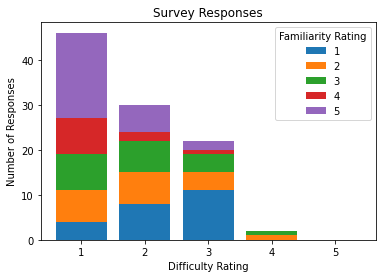

In [6]:
from matplotlib import pyplot as plt
import numpy as np
# Map difficult value to list of familiarities for that value
diffs = defaultdict(list)
for fam, diff in zip(allFams, allDiffs):
    diffs[diff].append(fam)

diffs = {k: list(sorted(v)) for k, v in diffs.items()}

counts = {
    1: [0, 0, 0, 0, 0], 
    2: [0, 0, 0, 0, 0],
    3: [0, 0, 0, 0, 0],
    4: [0, 0, 0, 0, 0], 
    5: [0, 0, 0, 0, 0]
}
for k, v in diffs.items():
    for famRating in set(v):
        count = v.count(famRating)
        # print('*', famRating, count)
        counts[k][famRating-1] = count

labels = [1, 2, 3, 4, 5]
colors = ['black', 'green', 'blue', 'yellow', 'red']

fig, ax = plt.subplots()
oldHeights = np.array([0, 0, 0, 0, 0])
for i, (k, _) in enumerate(counts.items()):
    newHeights = np.array([v[i] for v in counts.values()])
    ax.bar(labels, newHeights, bottom=oldHeights, label=labels[i])
    oldHeights = oldHeights + newHeights
ax.legend(title='Familiarity Rating')
ax.set_xlabel('Difficulty Rating')
ax.set_ylabel('Number of Responses')
ax.set_title('Survey Responses')
fig.savefig('survey_responses')

In [12]:
def calcPercentage(a, b):
    '''Return a / b as a percentage'''
    return a / b * 100

for k, v in counts.items():
    print(k, v)
print(calcPercentage(sum(counts[1][3:]), sum(counts[1])))
print(calcPercentage(sum(counts[1][:1]), sum(counts[1])))

print(calcPercentage(sum(counts[3][3:]), sum(counts[3])))
print(calcPercentage(sum(counts[3][:1]), sum(counts[3])))

1 [4, 7, 8, 8, 19]
2 [8, 7, 7, 2, 6]
3 [11, 4, 4, 1, 2]
4 [0, 1, 1, 0, 0]
5 [0, 0, 0, 0, 0]
58.69565217391305
8.695652173913043
13.636363636363635
50.0


[15, 17, 10, 15, 8, 15, 14, 9, 25, 13, 15, 13, 13, 0, 12, 16, 13, 11, 17, 5, 13, 13, 14, 14, 15, 12, 14, 25, 10, 16, 4, 15, 10, 17, 15, 17, 17, 25, 14, 16, 15, 16, 15, 15, 25, 25, 25, 25, 25, 25]
15.26


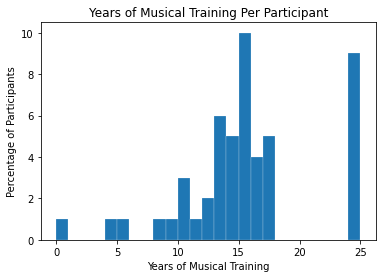

In [14]:
years = [a[0] for a in assignmentAnswersLookup.values()]
print(years)
print(np.mean(years))
fig, ax = plt.subplots()
ax.hist(years, bins=25, linewidth=0.2, edgecolor='white')
ax.set_title('Years of Musical Training Per Participant')
ax.set_ylabel('Percentage of Participants')
ax.set_xlabel('Years of Musical Training')
fig.show()